In [1]:
import torch
import torchvision
from torch import nn
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchinfo import summary
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path="/kaggle/input/face-expression-recognition-dataset/images"
train_dir=os.path.join(image_path,"train")
test_dir=os.path.join(image_path,"validation")

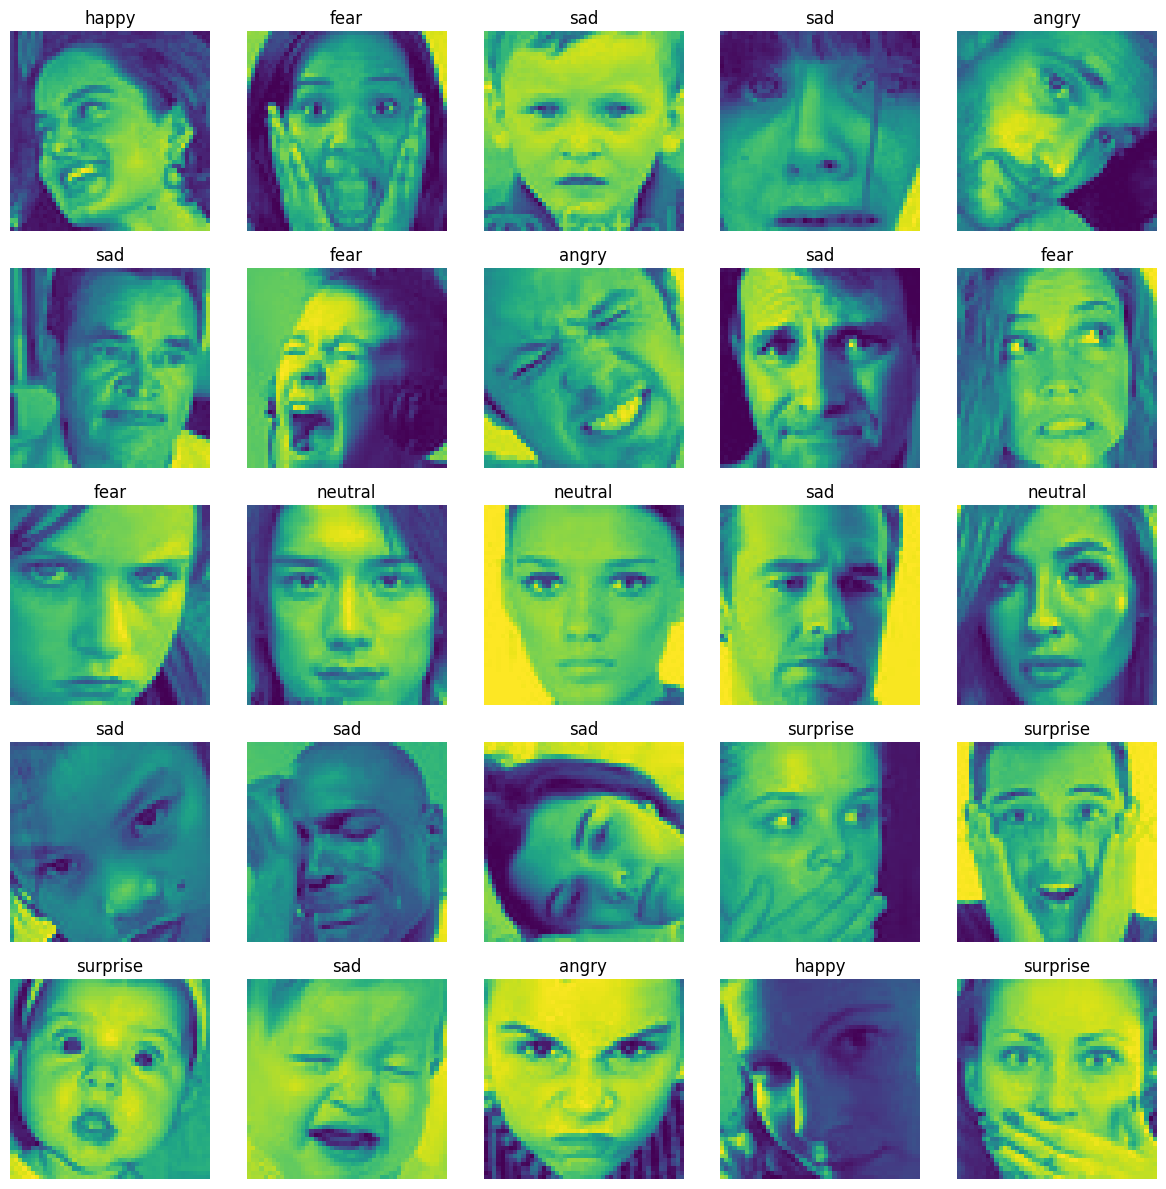

In [4]:
# Get list of classes and image paths
classes = os.listdir(train_dir)
all_images = []

for cls in classes:
    class_path = os.path.join(train_dir, cls)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    all_images.extend(images)

# Randomly select 25 images
random_images = random.sample(all_images, 25)

# Plot the 5x5 grid
plt.figure(figsize=(12, 12))

for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # show class label

plt.tight_layout()
plt.show()

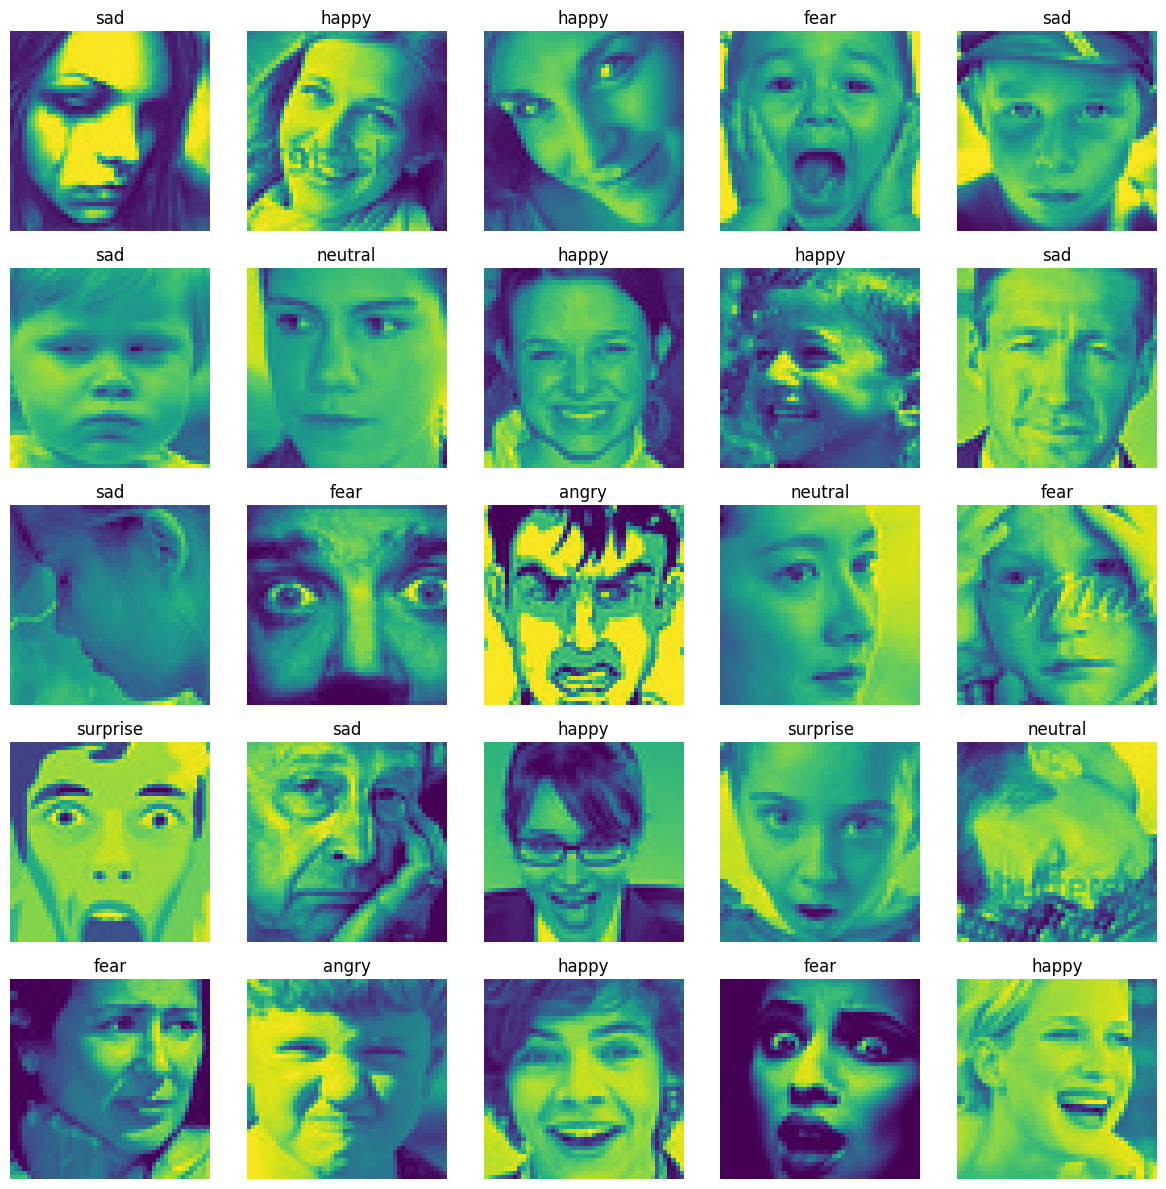

In [5]:
# Get list of classes and image paths
classes = os.listdir(test_dir)
all_images = []

for cls in classes:
    class_path = os.path.join(test_dir, cls)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    all_images.extend(images)

# Randomly select 25 images
random_images = random.sample(all_images, 25)

# Plot the 5x5 grid
plt.figure(figsize=(12, 12))

for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # show class label

plt.tight_layout()
plt.show()

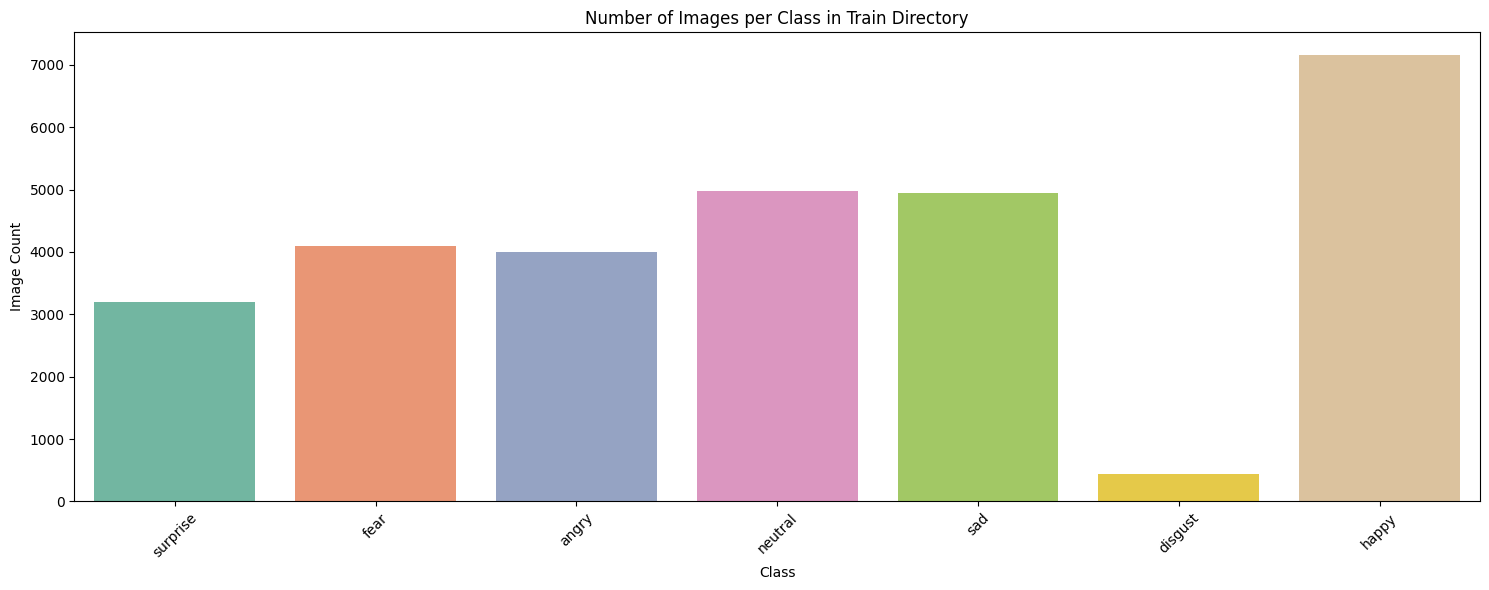

In [6]:
# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Convert to DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])

# Plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(data=df_counts, x='Class', y='Image Count', palette='Set2')
plt.title("Number of Images per Class in Train Directory")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

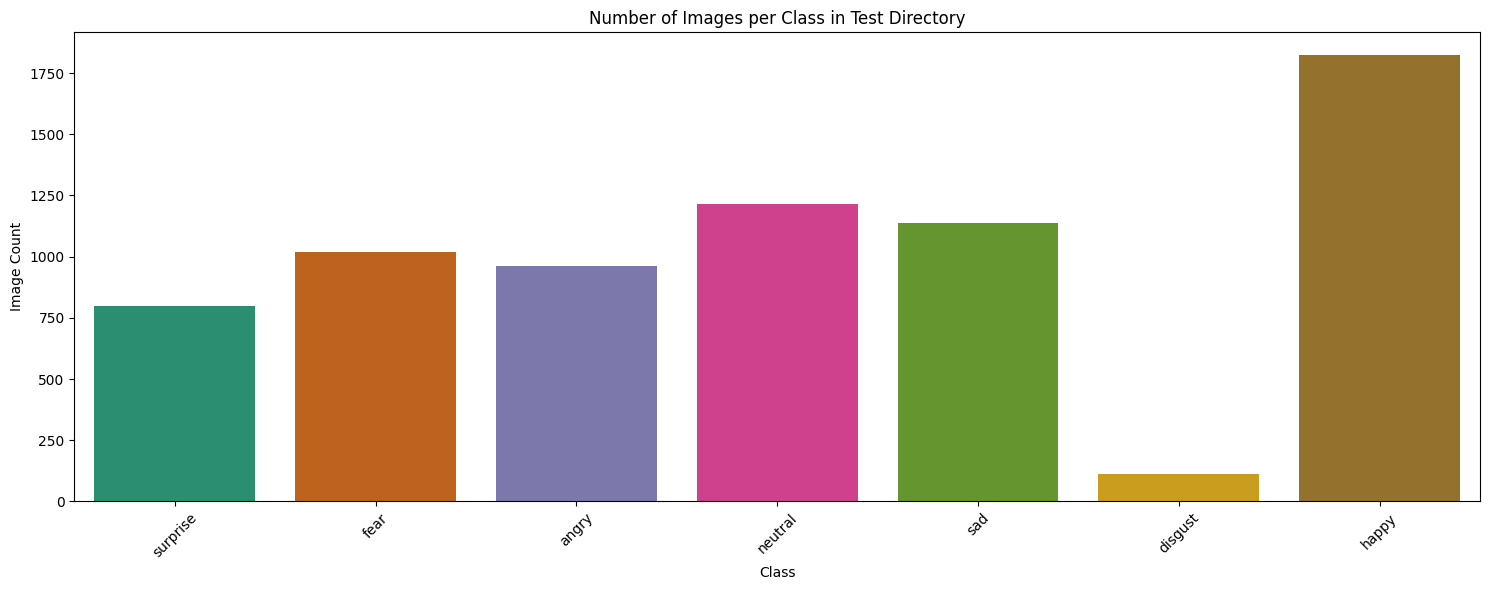

In [7]:
class_counts = {}

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Convert to DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])

# Plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(data=df_counts, x='Class', y='Image Count', palette='Dark2')
plt.title("Number of Images per Class in Test Directory")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Lambda(lambda image: image.convert("RGB")),  # always 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
image_path=Path(image_path)
image_path_list = list(image_path.glob("*/*/*.jpg"))

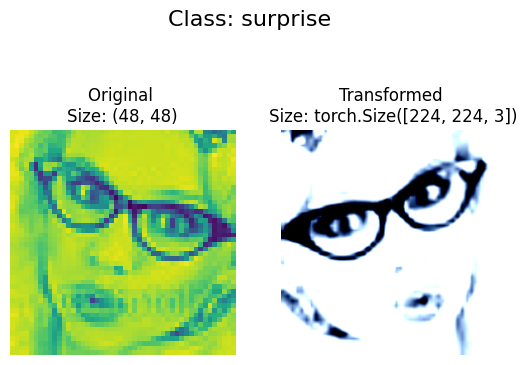

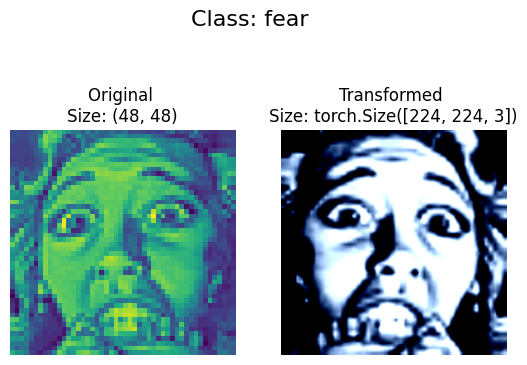

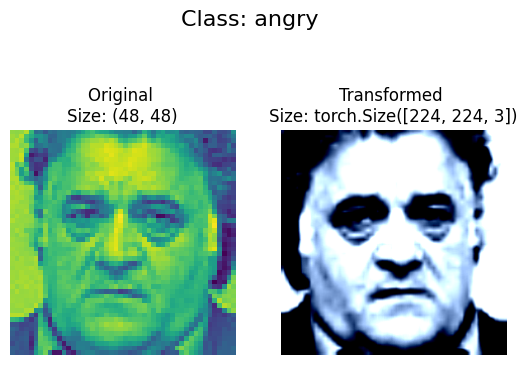

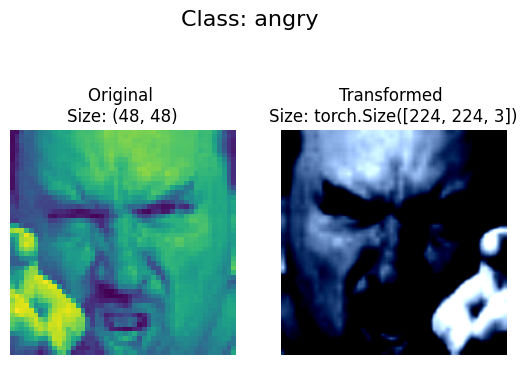

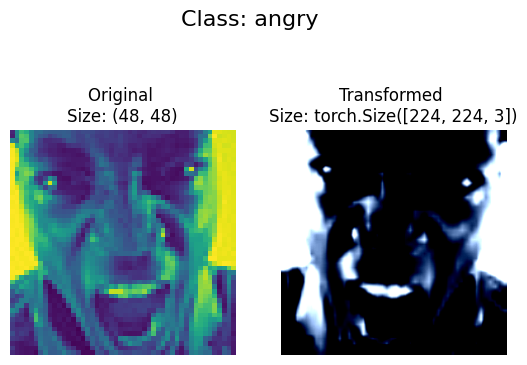

In [9]:
def plot_transformed_images(image_paths, transform, n=5, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=5)

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 28821
    Root location: /kaggle/input/face-expression-recognition-dataset/images/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               Lambda()
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 7066
    Root location: /kaggle/input/face-expression-recognition-dataset/images/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               Lambda()
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [11]:
class_names = train_data.classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
class_dict = train_data.class_to_idx
class_dict

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [13]:
len(train_data), len(test_data)

(28821, 7066)

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-0.8849, -0.8849, -0.8849,  ..., -1.4329, -1.4329, -1.4329],
         [-0.8849, -0.8849, -0.8849,  ..., -1.4329, -1.4329, -1.4329],
         [-0.8849, -0.8849, -0.8849,  ..., -1.4329, -1.4329, -1.4329],
         ...,
         [-0.7993, -0.7993, -0.7993,  ..., -0.7137, -0.7308, -0.7308],
         [-0.7993, -0.7993, -0.7993,  ..., -0.6965, -0.7137, -0.7137],
         [-0.7993, -0.7993, -0.7993,  ..., -0.6965, -0.7137, -0.7137]],

        [[-0.7752, -0.7752, -0.7752,  ..., -1.3354, -1.3354, -1.3354],
         [-0.7752, -0.7752, -0.7752,  ..., -1.3354, -1.3354, -1.3354],
         [-0.7752, -0.7752, -0.7752,  ..., -1.3354, -1.3354, -1.3354],
         ...,
         [-0.6877, -0.6877, -0.6877,  ..., -0.6001, -0.6176, -0.6176],
         [-0.6877, -0.6877, -0.6877,  ..., -0.5826, -0.6001, -0.6001],
         [-0.6877, -0.6877, -0.6877,  ..., -0.5826, -0.6001, -0.6001]],

        [[-0.5495, -0.5495, -0.5495,  ..., -1.1073, -1.1073, -1.1073],
         [-0.5495, -0.5495, -0.

In [15]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=8, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=8, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x787af7593f50>,
 <torch.utils.data.dataloader.DataLoader at 0x787af5b72ed0>)

In [16]:
import torchvision.models as models
from torchsummary import summary
from tqdm import tqdm
from tabulate import tabulate
import numpy as np
import time

class FacialExpressionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(FacialExpressionResNet, self).__init__()
        # Load pre-trained ResNet-18
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
              
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)


model = FacialExpressionResNet(num_classes=7).to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Training and validation loop with timing
def train_and_validate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []
    
    for epoch in range(num_epochs):
        start_time = time.time()  # Start timing
        
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update training metrics
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({"Loss": loss.item(), "Acc": 100. * train_correct / train_total})
        
        train_loss = train_loss / train_total
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_bar = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)  # Fixed: Removed stray "+"
        
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Update validation metrics
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                val_bar.set_postfix({"Loss": loss.item(), "Acc": 100. * val_correct / val_total})
        
        val_loss = val_loss / val_total
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Calculate epoch time in minutes
        epoch_time = (time.time() - start_time) / 60.0  # Convert to minutes
        epoch_times.append(epoch_time)
        
        # Display metrics in a table
        table = [
            ["Phase", "Loss", "Accuracy (%)", "Time (min)"],
            ["Train", f"{train_loss:.4f}", f"{train_accuracy:.2f}", f"{epoch_time:.2f}"],
            ["Validation", f"{val_loss:.4f}", f"{val_accuracy:.2f}", "-"]
        ]
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(tabulate(table, headers="firstrow", tablefmt="grid"))
    
    # Return metrics for plotting
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "epoch_times": epoch_times
    }


In [19]:
num_epochs = 10 
metrics = train_and_validate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs)


Epoch 1/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 1.5323 |          39.93 | 3.99         |
+------------+--------+----------------+--------------+
| Validation | 1.2821 |          51.13 | -            |
+------------+--------+----------------+--------------+



Epoch 2/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 1.2444 |          52.98 | 1.94         |
+------------+--------+----------------+--------------+
| Validation | 1.1298 |          57.71 | -            |
+------------+--------+----------------+--------------+



Epoch 3/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 1.1345 |          57.34 | 2.00         |
+------------+--------+----------------+--------------+
| Validation | 1.0729 |          59.41 | -            |
+------------+--------+----------------+--------------+



Epoch 4/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 1.0528 |          60.33 | 1.99         |
+------------+--------+----------------+--------------+
| Validation | 1.0511 |          61.28 | -            |
+------------+--------+----------------+--------------+



Epoch 5/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 0.9814 |          62.99 | 2.00         |
+------------+--------+----------------+--------------+
| Validation | 1.0131 |          62.54 | -            |
+------------+--------+----------------+--------------+



Epoch 6/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 0.9137 |          65.9  | 1.96         |
+------------+--------+----------------+--------------+
| Validation | 0.9897 |          63.23 | -            |
+------------+--------+----------------+--------------+



Epoch 7/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 0.8444 |          68.43 | 1.93         |
+------------+--------+----------------+--------------+
| Validation | 0.9954 |          64.08 | -            |
+------------+--------+----------------+--------------+



Epoch 8/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 0.7697 |          71.49 | 1.94         |
+------------+--------+----------------+--------------+
| Validation | 1.0386 |          63.43 | -            |
+------------+--------+----------------+--------------+



Epoch 9/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 0.6855 |          74.74 | 1.97         |
+------------+--------+----------------+--------------+
| Validation | 1.0173 |          64.49 | -            |
+------------+--------+----------------+--------------+



Epoch 10/10
+------------+--------+----------------+--------------+
| Phase      |   Loss |   Accuracy (%) | Time (min)   |
+============+========+================+==============+
| Train      | 0.5989 |          78.02 | 2.02         |
+------------+--------+----------------+--------------+
| Validation | 1.1153 |          62.95 | -            |
+------------+--------+----------------+--------------+


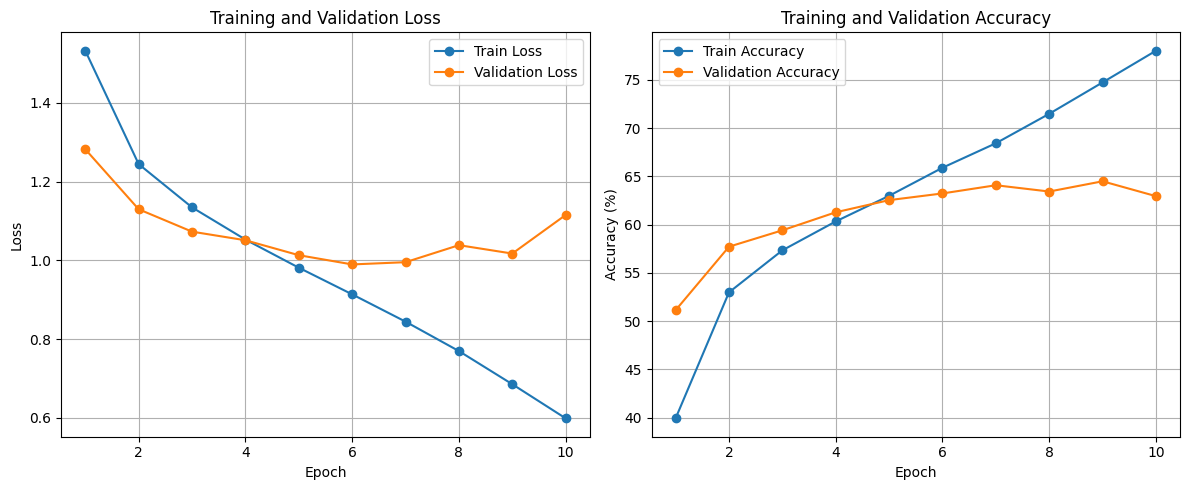

In [20]:
# Plot training and validation metrics
def plot_metrics(metrics):
    epochs = range(1, len(metrics["train_losses"]) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_losses"], label="Train Loss", marker='o')
    plt.plot(epochs, metrics["val_losses"], label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_accuracies"], label="Train Accuracy", marker='o')
    plt.plot(epochs, metrics["val_accuracies"], label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(metrics)

In [22]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    average_precision_score
)


def get_preds_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Collecting predictions"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [23]:
preds, labels = get_preds_and_labels(model, test_dataloader)


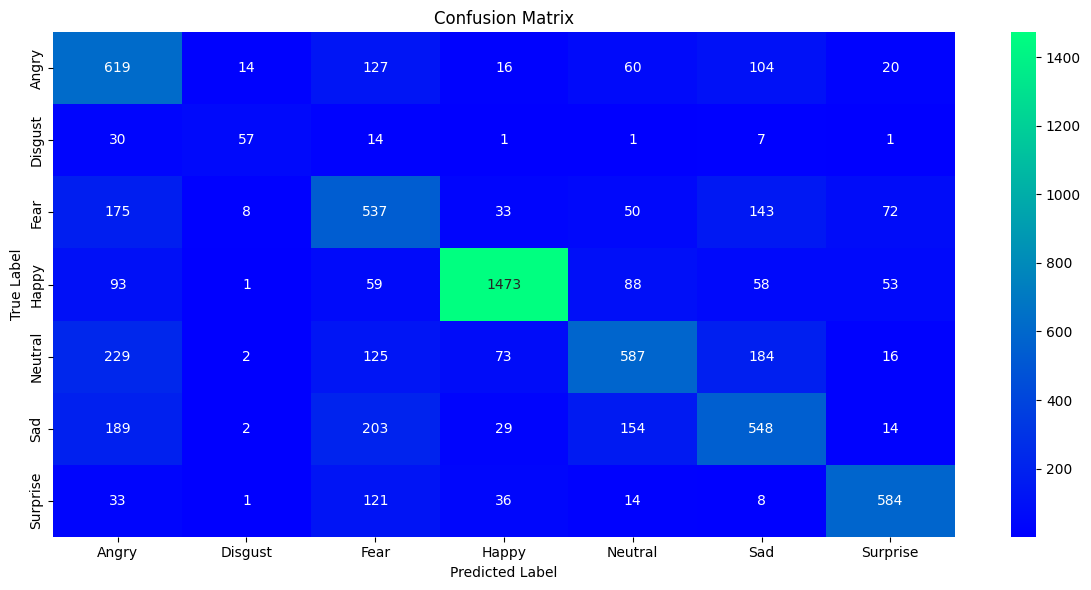

In [26]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="winter",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [27]:
print(classification_report(labels, preds, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.45      0.64      0.53       960
     Disgust       0.67      0.51      0.58       111
        Fear       0.45      0.53      0.49      1018
       Happy       0.89      0.81      0.85      1825
     Neutral       0.62      0.48      0.54      1216
         Sad       0.52      0.48      0.50      1139
    Surprise       0.77      0.73      0.75       797

    accuracy                           0.62      7066
   macro avg       0.62      0.60      0.61      7066
weighted avg       0.64      0.62      0.63      7066



In [28]:
from sklearn.preprocessing import label_binarize

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc="Collecting probs for ROC"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

n_classes = len(class_names)

# Binarize labels using the class index order [0...6]
labels_onehot = label_binarize(all_labels, classes=np.arange(n_classes))


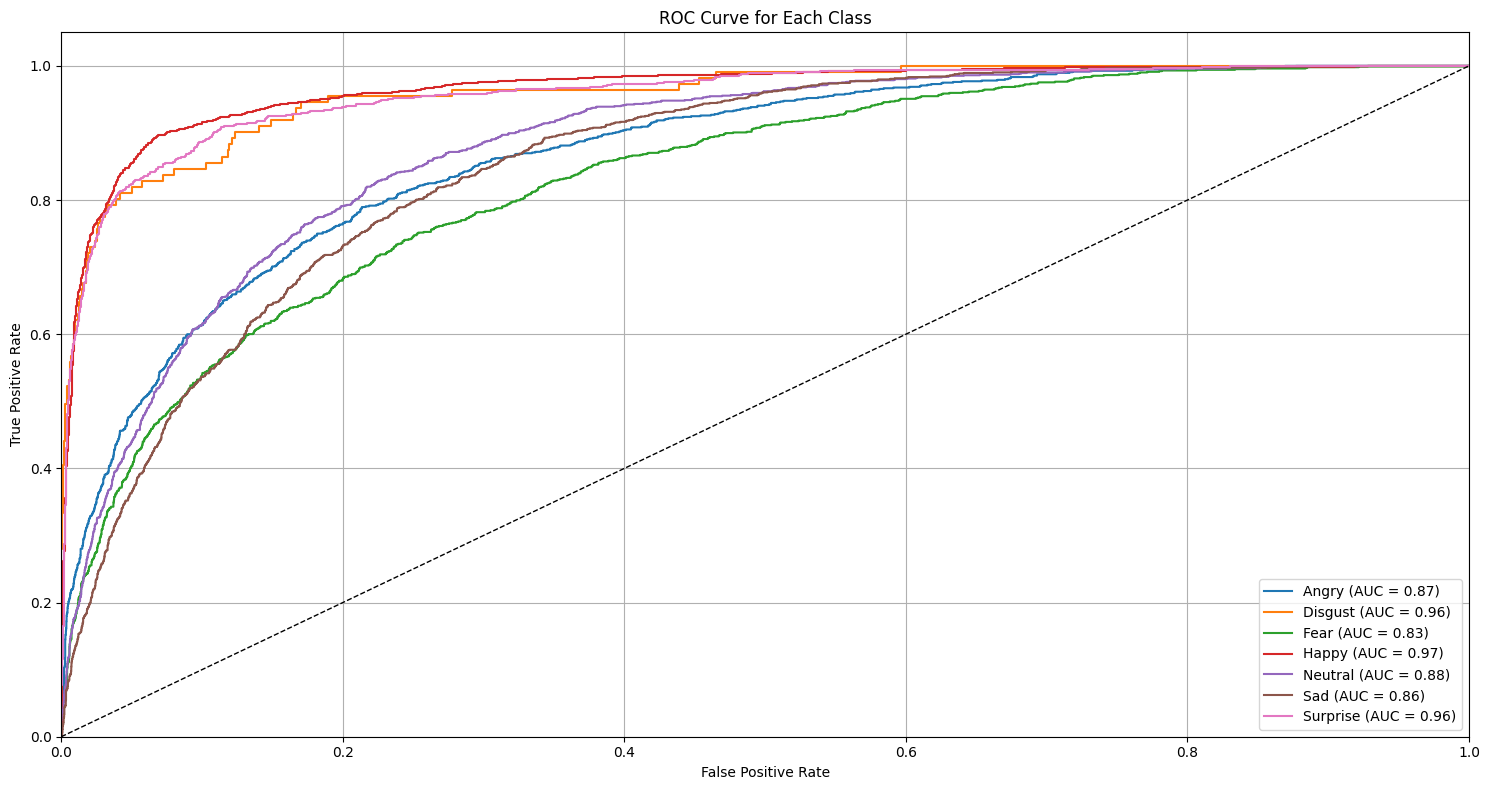

In [29]:
from sklearn.metrics import roc_curve, auc


plt.figure(figsize=(15, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Plot formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


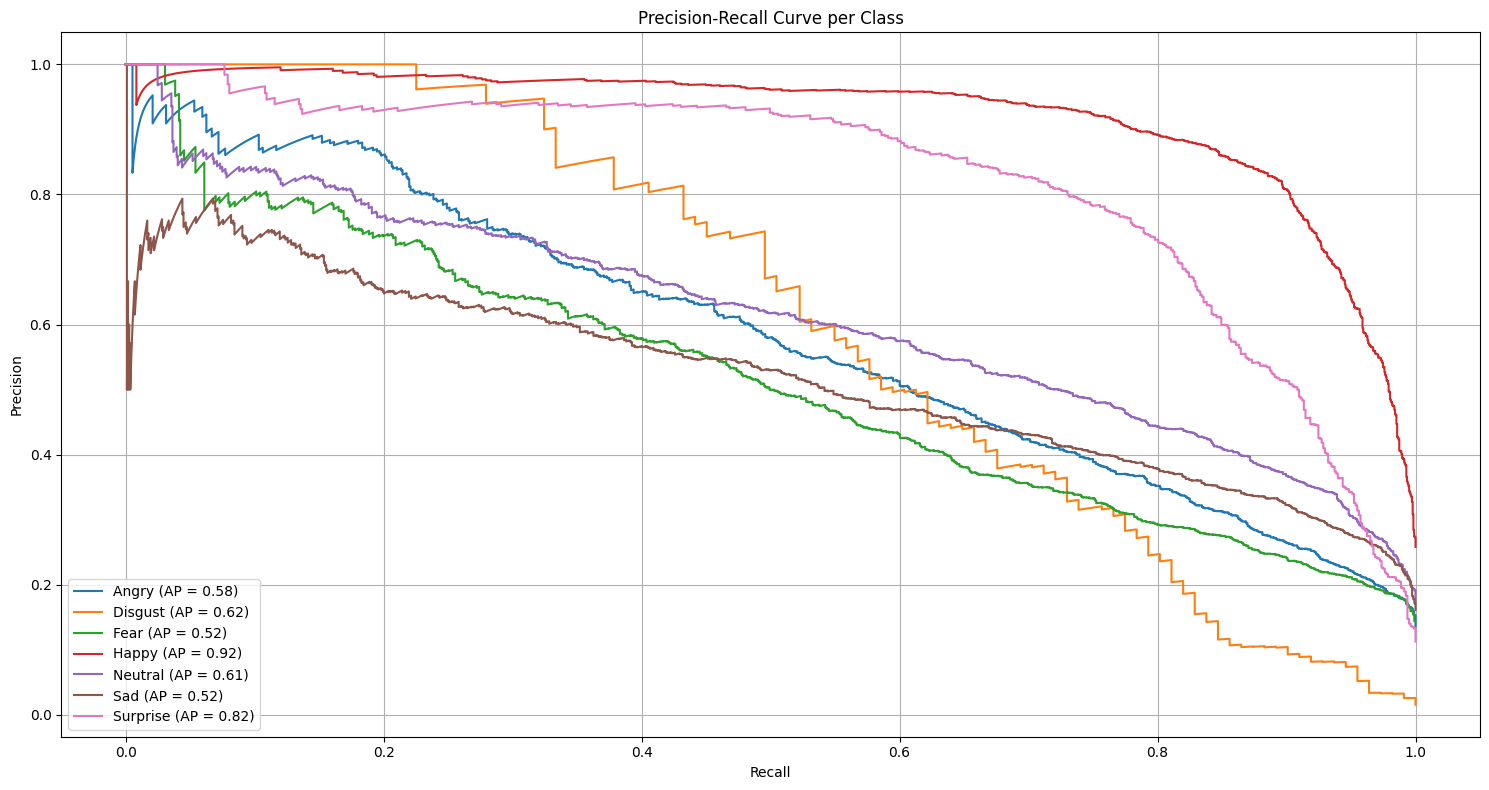

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score


plt.figure(figsize=(15, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(labels_onehot[:, i], all_probs[:, i])
    ap = average_precision_score(labels_onehot[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP = {ap:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


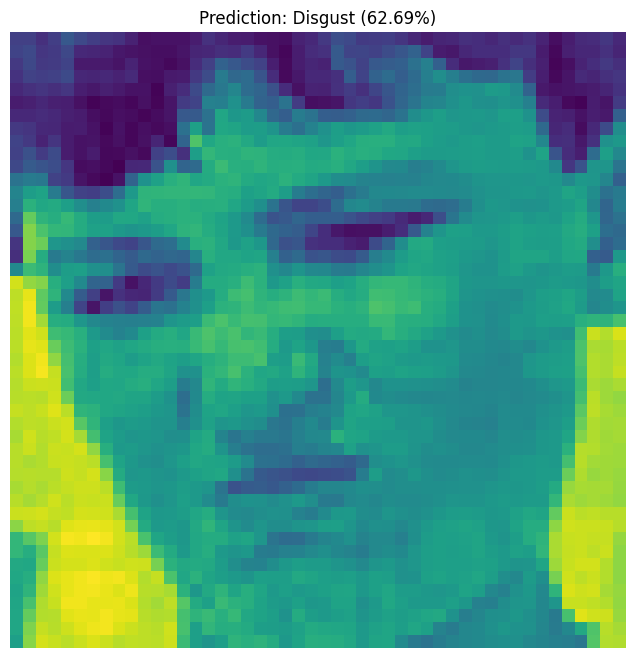

('Disgust', 0.6268612146377563)

In [32]:
def predict_and_plot(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path)
    
    # Transform image for model input
    input_tensor = data_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred_idx = torch.max(probs, 1)
    
    predicted_class = class_names[pred_idx.item()]
    confidence = conf.item()
    plt.figure(figsize=(10,8))
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence


class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
image_path = "/kaggle/input/face-expression-recognition-dataset/images/train/disgust/10018.jpg"  # Update this path
predict_and_plot(image_path, model, class_names)

In [33]:
# Define directory path
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)  # Create dir if not exists

# Define full file path
save_path = os.path.join(save_dir, "facial_expression_resnet.pth")

# Save model state_dict
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully in {save_path}")

Model saved successfully in saved_models/facial_expression_resnet.pth


In [35]:
import torch
print(torch.__version__)


2.6.0+cu124


In [36]:
import torchvision
print(torchvision.__version__)

0.21.0+cu124


In [34]:
! pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.18
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.1
arrow==1.3.0
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blobfile==3.0.0
blosc2==3.2.1
bokeh==3.6.3
Boruta==0.4.3
boto3==1.38.11
botocore==1.38.11
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper